## Task: Train a logistic regression classifier to predict survival of passengers in titanic dataset

You should download the data from GitHub in Day2 assessments (Titanic-Dataset.csv) dataset in the form of a csv

In the dataset, each row represents information about the passengers of titanic, Like their name, gender, class etc(See the dataframe below for more info).

The target column is 'Survived' which tells us whether this particular passenger sirvived or not

Use any of all the other columns as the input features (You can choose to drop the columns you see are not worth keeping).

Your task is to train a logistic regression model which takes the input featues (make sure to not accidentaly feed the 'Survived' column to the model as input) and predicts the whether a passenger with these features would survive or not.

Make sure to put emphasis on code quality and to include a way to judge how good your model is performing on **un-seen data (untrained data)**.

As a bonus, see if you can figure out which feature is most likely to affect the survivability of a passenger.

### Solved by: Asaad Hezam
Modified by: Hassan Alsayhah

In [1]:
from IPython.display import clear_output

In [2]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install gdown
%pip install catboost

clear_output()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Run this code to Install the data.
# IGNORE this part. Just downloading the data for you.


# Install gdown
!pip install -U -q gdown

# Import the library
import gdown

# Google Drive file link
link = "https://drive.google.com/file/d/1bQH8jclDL4mObMBZzueqcCY8IdQXLzul/view?usp=drive_link"

# Extract file ID from the link
file_id = link.split('/d/')[1].split('/')[0]

# Construct the direct download URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output_file = "Titanic-Dataset.csv"
gdown.download(download_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bQH8jclDL4mObMBZzueqcCY8IdQXLzul
To: /content/Titanic-Dataset.csv
100%|██████████| 61.2k/61.2k [00:00<00:00, 54.7MB/s]


'Titanic-Dataset.csv'

In [49]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
# Because Name and ID do not give any much information, we delete them. Also,
# After checking the values of Ticket, there is not much to gain from it.
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [51]:
# Checking the types and the number of non-null values per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [52]:
# 1. Do we have missing values?
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values[missing_values > 0])
    if missing_values.any():
        print("\nHandle Missing Values as needed.")
    else:
        print("\nNo Missing Values Found.")

check_missing_values(df)

Missing Values per Column:
Age         177
Cabin       687
Embarked      2
dtype: int64

Handle Missing Values as needed.


In [53]:
#for Age i will use the Average
age_average = df['Age'].mean()
df['Age'] = df['Age'].fillna(age_average)

In [54]:
# I will delete the Cabin column because the missing values in it are huge compared to the size of our data.
# 687 are missing out of 891! More than 50% of the data do not have Cabin.
# You should always delete the column in this case.
df = df.drop(['Cabin'], axis=1, inplace=False)

In [55]:
# Because Embarked just has 2 samples missing the values out of 891, just delete the 2 rows.
df.dropna(subset=['Embarked'], inplace=True)

In [56]:
check_missing_values(df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [57]:
# 2. Do we have duplicate samples?
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f"Number of Duplicate Samples: {duplicates}")
    if duplicates > 0:
        print("There are Duplicates.")
    else:
        print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 111
There are Duplicates.


In [58]:
# Dropping duplicates.
df.drop_duplicates(inplace=True)

In [59]:
# 3. Do we have categorical columns?
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    print("Categorical Columns:", list(categorical_cols))

label_encoders = encode_categorical_columns(df)

Categorical Columns: ['Sex', 'Embarked']


In [60]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df

Encoding column: Sex
Encoding column: Embarked


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
885,0,3,0,39.000000,0,5,29.1250,1
887,1,1,0,19.000000,0,0,30.0000,2
888,0,3,0,29.699118,1,2,23.4500,2
889,1,1,1,26.000000,0,0,30.0000,0


In [61]:
# 4. Do we have different scales in the data?
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
885,0,3,0,39.000000,0,5,29.1250,1
887,1,1,0,19.000000,0,0,30.0000,2
888,0,3,0,29.699118,1,2,23.4500,2
889,1,1,1,26.000000,0,0,30.0000,0


In [62]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = df.columns.drop("Survived")  ### DON'T SCALE THE TARGET
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1.0,1.0,0.271174,0.125,0.000000,0.014151,1.0
1,1,0.0,0.0,0.472229,0.125,0.000000,0.139136,0.0
2,1,1.0,0.0,0.321438,0.000,0.000000,0.015469,1.0
3,1,0.0,0.0,0.434531,0.125,0.000000,0.103644,1.0
4,0,1.0,1.0,0.434531,0.000,0.000000,0.015713,1.0
...,...,...,...,...,...,...,...,...
885,0,1.0,0.0,0.484795,0.000,0.833333,0.056848,0.5
887,1,0.0,0.0,0.233476,0.000,0.000000,0.058556,1.0
888,0,1.0,0.0,0.367921,0.125,0.333333,0.045771,1.0
889,1,0.0,1.0,0.321438,0.000,0.000000,0.058556,0.0


In [69]:
X = df.drop("Survived",axis=1)
y = df['Survived']

In [70]:
# Training our Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [71]:
model = LogisticRegression()

In [72]:
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

# Applying 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    # Split data into training and testing sets
    X_Train, X_Test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    model.fit(X_Train, y_Train)
    # Predict on the test set
    y_pred = model.predict(X_Test)

    # Calculate metrics
    scores_accuracy.append(accuracy_score(y_Test, y_pred))
    scores_precision.append(precision_score(y_Test, y_pred, average='weighted'))
    scores_recall.append(recall_score(y_Test, y_pred, average='weighted'))
    scores_f1.append(f1_score(y_Test, y_pred, average='weighted'))

# Print the results
print(f"Accuracy: {np.mean(scores_accuracy):.4f}")
print(f"Precision: {np.mean(scores_precision):.4f}")
print(f"Recall: {np.mean(scores_recall):.4f}")
print(f"F1-Score: {np.mean(scores_f1):.4f}")
print("\n")

Accuracy: 0.7700
Precision: 0.7696
Recall: 0.7700
F1-Score: 0.7690




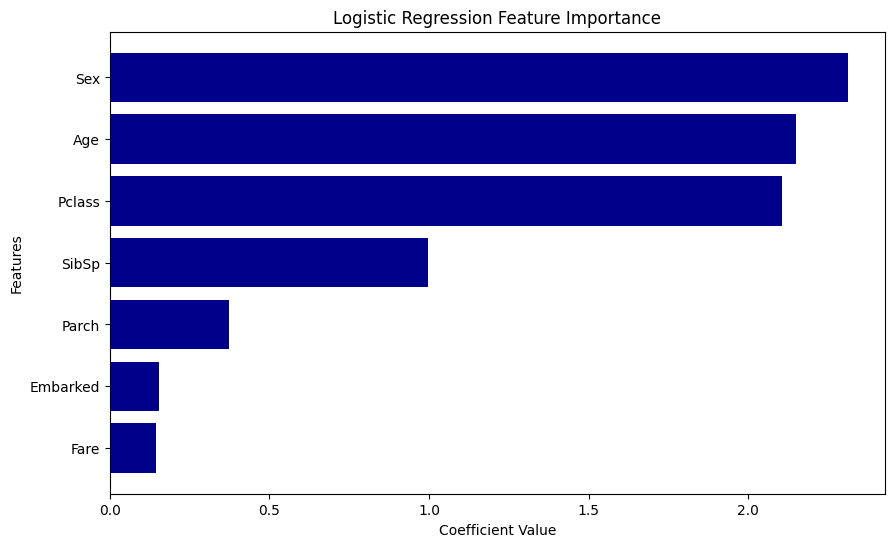

In [73]:
# Retrieve Logistic Regression coefficients and sort by absolute importance
logistic_importance = list(zip(X.columns, model.coef_[0]))
sorted_logistic_importance = sorted(logistic_importance, key=lambda x: abs(x[1]), reverse=True)

# Extract sorted features and their coefficients
features, coefficients = zip(*sorted_logistic_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, np.abs(coefficients), color='darkblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()